# 1 Etude du problème d’optimisation





#### Q1 
La minimisation de $K(x_{N}-L/2)^2$ permet de répondre à la contrainte d'arrosage : on doit arroser le parterre de fleur situé en (0,1). On cherche donc à minimiser la distance du bout du tuyau à ce point d'intérêt. 
La minimisation de la quantité $\sum_{i=0}^N{\lvert y_{i}\rvert}$ traduit la minimisation de la hauteur moyenne du tuyau (selon l'axe y). En minimisant cette somme on cherche à "compacter" le tuyau proche de l'axe x.


#### Q2
La valeur initiale qu'on doit donner au solveur doit vérifier les contraintes. Il serait compliqué de trouver/prouver l'existence d'une telle solution ie avec deux conditions aux bords ainsi qu'une condition de courbure (la courbure à des conditions aux bords et elle est bornée).

#### Q3
Les $y_{i}\mapsto\lvert y_{i}\rvert$ ne sont pas différentiables sur $\mathbb{R}$. Ce manque de régularité pose évidemment problème dans l'algorithme de minimisation. 



#### Q4



#### Q5
On considère la variable de décision : 
$z = (\theta_{0},...,\theta_{N-1},x_{0},...,x_{N},y_{0},...,y_{N},w_{0},...w_{N})$\
La fonction cout : 
$f:z\mapsto K(x_{N}-L/2)^2+ ds\sum_{i=0}^{N}{w_{i}}$\
La fonction contrainte inégalité :
$c_{ineq}:z\mapsto (\theta_{1}-\theta_{0} -\alpha ds,\theta_{0}-\theta_{1} -\alpha ds,...,\theta_{N-1}-\theta_{N-2} -\alpha ds,...,\theta_{N-2}-\theta_{N-1} -\alpha ds,-w_{0}-y_{0},-w_{0}+y_{0},...,-w_{N}-y_{N},-w_{N}+y_{N})$\
La fonction contrainte égalité :
$c_{eq}:z\mapsto (\theta_{0},\theta_{N-1},x_{0},y_{0}-1,y{N},x_{1}-x_{0}- ds cos(\theta_{0}),...,x_{N}-x_{N-1}- ds cos(\theta_{N-1}),y_{1}-y_{0}- ds sin(\theta_{0}),...,y_{N}-y_{N-1}- dssin(\theta_{N-1}))$



# 2 Etude et résolution numériques


#### Q6
On peut implémenter un algorithme de résolution avec Scipy ou Casadi. Afin de résoudre ce problème d'optimisation, nous allons utiliser le solveur SLSQP qui est dans le module Scipy.


#### Q7

0.2
[0.         0.2        0.39891197 0.59782394 0.79673591 0.99564788
 1.19455986 1.39347183 1.5923838  1.79129577 1.99020774 2.18911971
 2.38803168 2.58694365 2.78585562 2.98476759 3.18367957 3.38259154
 3.58150351 3.78041548 3.97932745 4.17823942 4.37715139 4.57606336
 4.77497533 4.9738873  5.17279928 5.37171125 5.57062322 5.76953519
 5.96844716 6.16735913 6.3662711  6.56518307 6.76409504 6.96300702
 7.16191899 7.36083096 7.55974293 7.7586549  7.95756687 8.15647884
 8.35539081 8.55430278 8.75321475 8.95212673 9.1510387  9.34995067
 9.54886264 9.74777461 9.94777461]


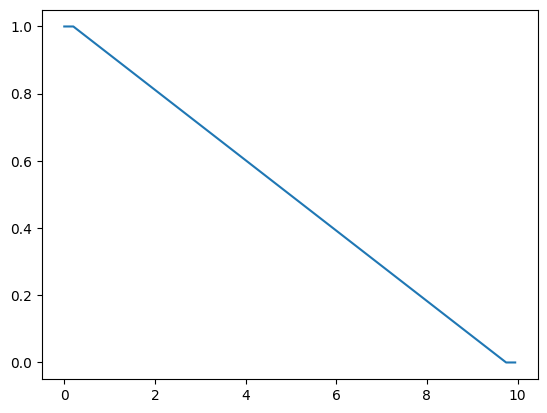

In [4]:
import numpy as np
import matplotlib.pyplot as plt

K=1
N=50
L=10
ds=L/N
a=1
thetamax=a*ds


def ConditionInitDroite(N,ds):
    ##1)on trouve dans un premier temps la condition initiale :
    m=N+(N+1)+(N+1)+(N+1)
    z_0=np.zeros(m) #theta initial est nul
    #en tracant la droite reliant les point (1,0) et l'axe des abscisses en prenant compte des theta initial et final, theta est donc constant
    theta = -np.arcsin(1/((L-2*ds)))
    z_0[2*N+1]=1
    z_0[3*N+2]=1
    for i in range (1,N-1) :
        z_0[i]=theta
    for i in range (N+1,2*N+1):
        z_0[i]=z_0[i-1]+ds*np.cos(z_0[i-(N+1)])
        z_0[i+N+1]=z_0[i+N]+ds*np.sin(z_0[i-(N+1)])
        z_0[i+2*(N+1)]=z_0[i+N+1]
    return z_0

z_0=ConditionInitDroite(N,ds)
print(thetamax)
print(z_0[N:2*N+1])
plt.plot(z_0[N:2*N+1],z_0[2*N+1:3*N+2])
    
    

In [5]:
import numpy as np
from scipy.optimize import minimize

#Définition de la fonction coût
def cout(z):
    return K*(z[2*N]-L/2)**2 + ds*np.sum(z[3*N+2:]) # La somme correspond à la somme des Omega_i

#Définition des contraintes

#Attention les contraintes sont du côté positif, d'après la doc : 'Equality constraint means that the 
# constraint function result is to be zero whereas inequality means that it is to be non-negative.'

def vectContrainte(N,ds):

    def contrainte_theta0(z):
        return z[0]
    def contrainte_thetaN1(z):
        return z[N-1]
    def contrainte_x0(z):
        return z[N]
    def contrainte_y0(z):
        return z[2*N+1]-1
    def contrainte_yN(z):
        return z[3*N+1]
    
    def créer_contraintes_i_1_theta(i):
        def contrainte(z):
            return z[i+1]-z[i]+a*ds
        return contrainte

    def créer_contraintes_i_2_theta(i):
        def contrainte(z):
            return z[i]-z[i+1]+a*ds
        return contrainte

    def créer_contraintes_i_1_omega(i):
        def contrainte(z):
            return z[3*N+2+i]-z[2*N+1+i]
        return contrainte

    def créer_contraintes_i_2_omega(i):
        def contrainte(z):
            return z[3*N+2+i]+z[2*N+1+i]
        return contrainte

    def créer_contraintes_e_x(i):
        def contrainte(z):
            return z[N+1+i]-z[N+i]-ds*np.cos(z[i])
        return contrainte

    def créer_contraintes_e_y(i):
        def contrainte(z):
            return z[2*N+2+i]-z[2*N+1+i]-ds*np.sin(z[i])
        return contrainte

    contraintes=[]
    #Ajout des contraintes égalités qui ne dépendent pas de i
    contraintes.append({'type': 'eq', 'fun': contrainte_theta0})
    contraintes.append({'type': 'eq', 'fun': contrainte_thetaN1})
    contraintes.append({'type': 'eq', 'fun': contrainte_x0})
    contraintes.append({'type': 'eq', 'fun': contrainte_y0})
    contraintes.append({'type': 'eq', 'fun': contrainte_yN})


    #Ajout des contraintes qui dépendent de i, d'abord les inégalités puis les égalités
    for i in range(N):
        contraintes.append({'type': 'ineq', 'fun': créer_contraintes_i_1_theta(i)})
    for i in range(N):
        contraintes.append({'type': 'ineq', 'fun': créer_contraintes_i_2_theta(i)})
    for i in range(N+1):
        contraintes.append({'type': 'ineq', 'fun': créer_contraintes_i_1_omega(i)})
    for i in range(N+1):
        contraintes.append({'type': 'ineq', 'fun': créer_contraintes_i_2_omega(i)})
    for i in range(N):
        contraintes.append({'type': 'eq', 'fun': créer_contraintes_e_x(i)})
    for i in range(N):
        contraintes.append({'type': 'eq', 'fun': créer_contraintes_e_y(i)})

    return contraintes

In [6]:
contraintes=vectContrainte(N,ds)
sol = minimize(cout,z_0,method='SLSQP', constraints=contraintes)
print(sol)

#On affiche la solution pour voir si la minimisation a fonctionné

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 8.393576046150326
       x: [ 0.000e+00 -2.000e-01 ... -6.677e-16  7.642e-17]
     nit: 48
     jac: [ 0.000e+00  0.000e+00 ...  2.000e-01  2.000e-01]
    nfev: 9793
    njev: 48


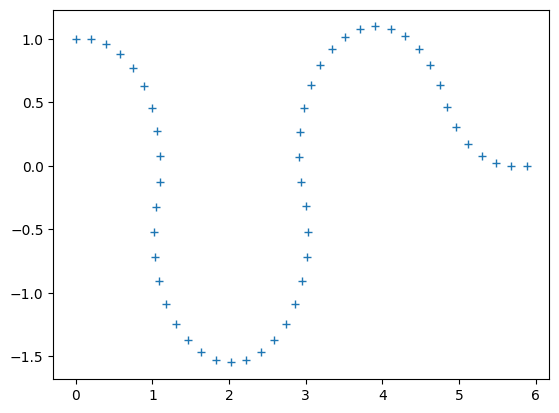

In [ ]:
plt.plot(sol.x[N:2*N+1],sol.x[2*N+1:3*N+2])

# Q8


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 9.045824266683086
       x: [ 0.000e+00 -2.000e-01 ...  6.193e-16  1.610e-15]
     nit: 53
     jac: [ 0.000e+00  0.000e+00 ...  2.000e-01  2.000e-01]
    nfev: 10814
    njev: 53


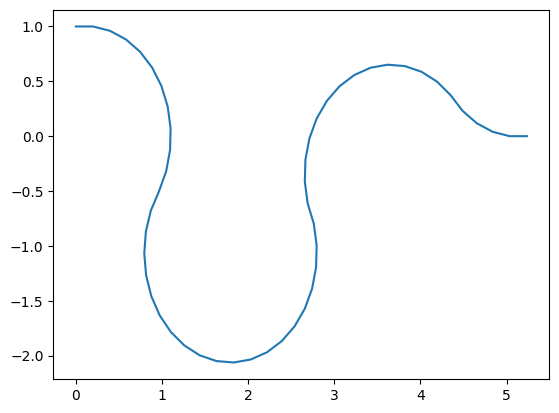

In [8]:
#Tracé pour K=5
K=5
N=50
L=10
ds=L/N
a=1
thetamax=a*ds
z_0=ConditionInitDroite(N,ds)
contraintes=vectContrainte(N,ds)
sol2=minimize(cout,z_0,method='SLSQP', constraints=contraintes)
print(sol2)
plt.plot(sol2.x[N:2*N+1],sol2.x[2*N+1:3*N+2])

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 10.50644630290102
       x: [ 0.000e+00  2.000e-01 ...  2.491e-15  2.359e-15]
     nit: 66
     jac: [ 0.000e+00  0.000e+00 ...  2.000e-01  2.000e-01]
    nfev: 13467
    njev: 66


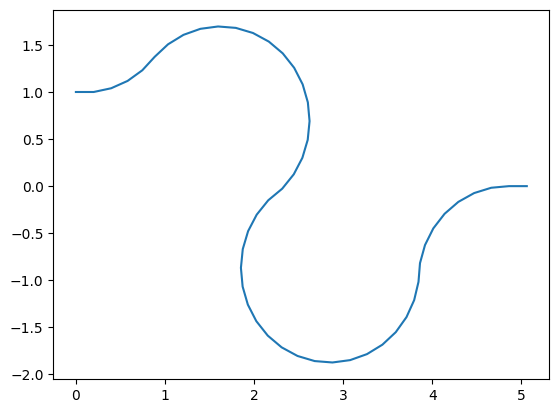

In [9]:
#Tracé pour K=10
K=10
N=50
L=10
ds=L/N
a=1
thetamax=a*ds
z_0=ConditionInitDroite(N,ds)
contraintes=vectContrainte(N,ds)
sol3=minimize(cout,z_0,method='SLSQP', constraints=contraintes)
print(sol3)
plt.plot(sol3.x[N:2*N+1],sol3.x[2*N+1:3*N+2])

# Q9

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 10.496225482699257
       x: [ 0.000e+00  1.429e-01 ...  1.084e-15  3.107e-15]
     nit: 49
     jac: [ 0.000e+00  0.000e+00 ...  1.429e-01  1.429e-01]
    nfev: 13921
    njev: 49


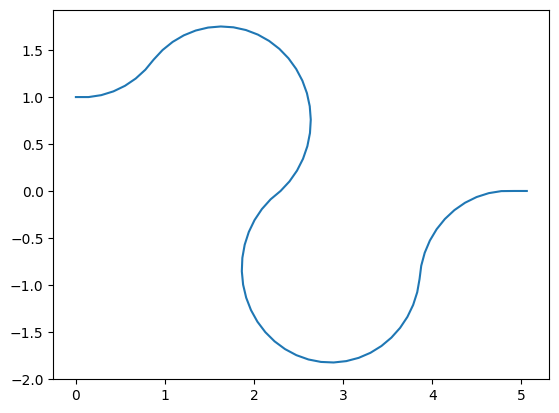

In [10]:
#Tracé pour K=10 et N=70
K=10
N=70
L=10
ds=L/N
a=1
thetamax=a*ds
z_0=ConditionInitDroite(N,ds)
contraintes=vectContrainte(N,ds)
sol4=minimize(cout,z_0,method='SLSQP', constraints=contraintes)
print(sol4)
plt.plot(sol4.x[N:2*N+1],sol4.x[2*N+1:3*N+2])

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 10.428712649929262
       x: [ 0.000e+00  1.111e-01 ... -4.695e-15 -4.964e-15]
     nit: 44
     jac: [ 0.000e+00  0.000e+00 ...  1.111e-01  1.111e-01]
    nfev: 16020
    njev: 44


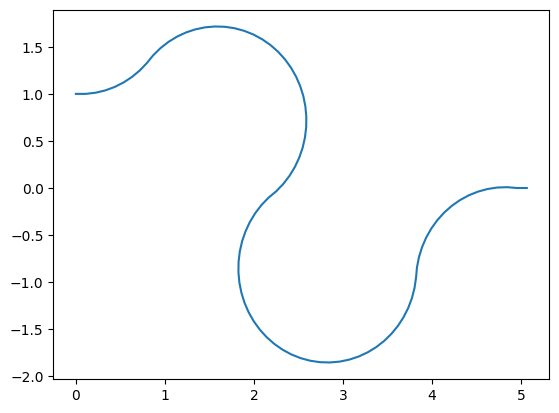

In [11]:
#Tracé pour K=10 et N=90
K=10
N=90
L=10
ds=L/N
a=1
thetamax=a*ds
z_0=ConditionInitDroite(N,ds)
contraintes=vectContrainte(N,ds)
sol5=minimize(cout,z_0,method='SLSQP', constraints=contraintes)
print(sol5)
plt.plot(sol5.x[N:2*N+1],sol5.x[2*N+1:3*N+2])

# Q10

La nouvelle valeur initiale doit respecter les contraintes et particulièrement la contrainte de courbure. Calculons ainsi l'angle theta entre le point troisième point et le quatrième point.